In [31]:
# All imports

%matplotlib inline

import cv2
import glob, os
import imageio
import matplotlib.pyplot as plt
import numpy
import sys

from keras import backend as K
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.models import Sequential

from skimage import feature
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC

from keras.preprocessing.image import img_to_array, array_to_img
from keras.utils.vis_utils import model_to_dot

from IPython.display import SVG, display


In [55]:
# Common Constants
IMG_WIDTH = 32
IMG_HEIGHT = 32

USE_RAW_IMAGE_FEATURES = True
USE_CANNY_IMAGE_FEATURES = True

if K.image_data_format() == 'channels_first':
    INPUT_SHAPE = (3, IMG_WIDTH * 2, IMG_HEIGHT)
else:
    INPUT_SHAPE = (IMG_WIDTH * 2, IMG_HEIGHT, 3)

In [4]:
# All image processing and plot related

def plotImage(image):
    cv_rgb2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb2)
    plt.show()

def plotImageFromPath(imagePath):
    plotImage(cv2.imread(imagePath))

def shape_cannyEdgesOld(cv2Image, cannyImagePath):
    v = numpy.median(cv2Image)
    sigma = 0.0
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    #print "Lower", lower, "Upper", upper
    grayScaleImage = cv2.cvtColor(cv2Image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(grayScaleImage, 10, 255)
    cv2.imshow('Canny edges',edges)
    cv2.imwrite(cannyImagePath, edges)

def shape_cannyEdges(cv2Image, cannyImagePath):
    cv2Image[0,0] = (255, 0, 0)
    cv2Image[0,1] = (0, 255, 0)
    cv2Image[0,2] = (0, 0, 255)
    
    v = numpy.median(cv2Image)
    sigma = 0.0
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    #print "Lower", lower, "Upper", upper
    grayScaleImage = cv2.cvtColor(cv2Image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(grayScaleImage, 10, 255)
    cv2.imshow('Canny edges',edges)
    cv2.imwrite(cannyImagePath, edges)
    
def shape_hog(cv2Image, fileName): 
    grayScaleImage = cv2.cvtColor(cv2Image, cv2.COLOR_BGR2GRAY)
    fd, hog_image = feature.hog(grayScaleImage, orientations=8, pixels_per_cell=(16, 16),cells_per_block=(1, 1), visualise=True)
    
    cv2.imshow('HOG',hog_image)
    cv2.imwrite(fileName, hog_image)
    
def create_canny_edge_image(origImageDir, origImageName):
    
    origImagePath = origImageDir + '/' + origImageName
    print(origImagePath)
    
    cannyImageName = "canny_" + origImageName
    cannyImagePath = origImageDir + '/' + cannyImageName
    plainImage = cv2.imread(origImagePath)
    shape_cannyEdges(plainImage, cannyImagePath)
    
    return cannyImagePath
    
def create_canny_for_all_img(origImageDir):
    imgFiles = [filename for filename in os.listdir(origImageDir)
                if (not filename.startswith("canny") and filename.endswith(".jpg") )]
    for origImageName in imgFiles:
        cannyImageName = "canny_" + origImageName
        cannyImagePath = origImageDir + '/' + cannyImageName
        
        if not os.path.exists(cannyImagePath):
            create_canny_edge_image(origImageDir, origImageName)
            
def create_color_histogram (origImageDir, origImageName):
    origImagePath = origImageDir + '/' + origImageName
    plainImage = cv2.imread(origImagePath)
    
    hist = cv2.calcHist([plainImage], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = hist.flatten()
    print (hist)

In [44]:
# All image feature verctor related

def create_features_for_all_raw_img(origImageDir, isSpam):
    imgFiles = [filename for filename in os.listdir(origImageDir)
                if ((not filename.startswith("canny")) and filename.endswith(".jpg") )]

    res = [create_feature_vector(origImageDir, origImageName, isSpam) for origImageName in imgFiles]
    return numpy.array(res)
            
def create_features_for_all_canny_img(origImageDir, isSpam):
    imgFiles = [filename for filename in os.listdir(origImageDir)
                if (filename.startswith("canny") and filename.endswith(".jpg") )]
    res = [create_feature_vector(origImageDir, origImageName, isSpam) for origImageName in imgFiles]
    return numpy.array(res)
    
def create_feature_vector(origImageDir, origImageName, isSpam, numRow=IMG_HEIGHT, numCol=IMG_WIDTH):
    origImagePath = origImageDir + '/' + origImageName
    plainImage = cv2.imread(origImagePath)
    resizedImage = cv2.resize(plainImage, (numRow, numCol))
    h = resizedImage.shape[0]
    w = resizedImage.shape[1]
    res = numpy.ndarray(shape=(3, h, w), dtype=float, order='F')
    # loop over the image, pixel by pixel
    for y in range(0, h):
        for x in range(0, w):
            # threshold the pixel
            color = resizedImage[y,x] 
            res[0, y, x] = color[0] / 255.0
            res[1, y, x] = color[1] / 255.0
            res[2, y, x] = color[2] / 255.0
    return numpy.append(res.flatten(), isSpam)

def crete_canny_and_get_features_with_labels(directory, label, use_raw_images, use_canny_images):
    if (not use_raw_images) and (not use_canny_images):
        raise Exception('At least use_raw_images or use_canny_images need to be set to true')
        
    create_canny_for_all_img(directory)
    data_raw = create_features_for_all_raw_img(directory, label)
    data_canny = create_features_for_all_canny_img(directory, label)
    
    if (use_raw_images and use_canny_images):
        return numpy.column_stack((data_raw[:,:-1], data_canny))
    elif use_raw_images:
        return data_raw
    else:
        return data_canny

def get_feature_with_labels(
    ham_dir="NaturalImages",
    spam_dir="SpamImages",
    show=False,
    use_raw_images=True,
    use_canny_images=True
):
    data_ham = crete_canny_and_get_features_with_labels(
        directory=ham_dir,
        label=0,
        use_raw_images=use_raw_images,
        use_canny_images=use_canny_images
    )
    data_spam = crete_canny_and_get_features_with_labels(
        directory=spam_dir,
        label=1,
        use_raw_images=use_raw_images,
        use_canny_images=use_canny_images
    )
    
    data = numpy.concatenate((data_ham, data_spam), axis=0)
    numpy.random.shuffle(data)

    if show:
        #numpy.set_printoptions(threshold=sys.maxsize)
        numpy.set_printoptions(threshold=10)
        print("data_ham, using directory:", ham_dir)
        print(data_ham)
        print("data_spam, using directory:", spam_dir)
        print(data_spam)
        print("data")
        print(data)

    return data

In [189]:
# Plot related
def draw_accuracy_and_loss(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def draw_roc(y_predicted, y_actual):
    fpr, tpr, thresholds = roc_curve(y_predicted, y_actual)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
def add_plot(plt, svm_res, color, label):
    
    fpr, tpr, thresholds = roc_curve(svm_res[0], svm_res[1])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=color, lw=1, label=(label + ' ROC curve (area = %0.2f)') % roc_auc)
    
    
def draw_roc_for_all(svm_rbf_public, svm_linear_public, svm_rbf_cha1, svm_linear_cha1, svm_rbf_cha2, svm_linear_cha2):
    plt.figure()
    
    #fpr, tpr, thresholds = roc_curve(y_predicted, y_actual)
    #roc_auc = auc(fpr, tpr)
    
    #plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    
    add_plot(plt, svm_rbf_public, 'darkorange', 'SVM-RBF-DATASET1')
    add_plot(plt, svm_linear_public, 'blue', 'SVM-LINEAR-DATASET1')
    add_plot(plt, svm_rbf_cha1, 'green', 'SVM-RBF-DATASET2')
    add_plot(plt, svm_linear_cha1, 'magenta', 'SVM-LINEAR-DATASET2')
    add_plot(plt, svm_rbf_cha2, 'pink', 'SVM-RBF-DATASET3')
    add_plot(plt, svm_linear_cha2, 'brown', 'SVM-LINEAR-DATASET3')
    
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_keras_model(model, show_shapes=True, show_layer_names=True):
    model_svg = model_to_dot(model, show_shapes=show_shapes, show_layer_names=show_layer_names).create(prog='dot',format='svg')
    display(SVG(model_svg))
    
def draw_bar_chart(accuracies):
    plt.figure(figsize=(8, 3))
    
    min_y = min(accuracies.values()) - 10
    
    objects = accuracies.keys()
    y_pos = numpy.arange(len(accuracies.keys()))
    performance = accuracies.values()
    
    plt.ylim([min_y, 100])
    plt.margins(x=.01)

    plt.bar(y_pos, performance, align='center', color='green', width=0.6)
    plt.xticks(y_pos, objects)
    plt.xticks(rotation=90)
    plt.ylabel('Accuracy')
    plt.xlabel('No. of Samples')

In [91]:
# Machine learning algorithm related

# Feed forward
def run_feed_forward(data, do_plot=False):
    
    INPUT_DIMENSION = len(data[0]) - 1
    LAYER_1_DIMENSION = 300
    LAYER_2_DIMENSION = 300
    OUTPUT_DIMENSION = 1
    EPOCH = 100
    
    train_len = int(len(data) * .7)
    data_train = data[0:train_len]
    data_test = data[train_len:]

    num_col = len(data_train[0]) - 1

    x_train = data_train[:, 0:num_col]
    y_train = data_train[:, num_col:].flatten()

    x_test = data_test[:, 0:num_col]
    y_test = data_test[:, num_col:].flatten()
    
    # Early stopping  
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

    model = Sequential()
    model.add(Dense(LAYER_1_DIMENSION,
                    input_dim=INPUT_DIMENSION,
                    activation='relu'))
    # With regularizers
    #model.add(Dense(LAYER_1_DIMENSION,
    #                input_dim=INPUT_DIMENSION,
    #                activation='relu',
    #                kernel_regularizer=regularizers.l2(0.01),
    #                activity_regularizer=regularizers.l1(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(LAYER_2_DIMENSION,
                    activation='relu'))
    # With regularizers
    #model.add(Dense(LAYER_2_DIMENSION,
    #                activation='relu',
    #                kernel_regularizer=regularizers.l2(0.01),
    #                activity_regularizer=regularizers.l1(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(OUTPUT_DIMENSION, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    history = model.fit(x_train,
                        y_train,
                        epochs=EPOCH,
                        batch_size=64,
                        validation_split=0.15,
                        callbacks=[early_stop])
    
    score = model.evaluate(x_test, y_test, batch_size=64)
    
    if do_plot:
        print (score)
        plot_keras_model(model)
        draw_accuracy_and_loss(history)

    return score

# CNN
def run_cnn(data, do_plot=False):
    EPOCH = 100
    
    train_len = int(len(data) * .7)
    data_train = data[0:train_len]
    data_test = data[train_len:]

    num_col = len(data_train[0]) - 1

    # Convert 1d array back to image for convolution
    x_train_1D = data_train[:, 0:num_col]
    x_train = numpy.array([z.reshape(INPUT_SHAPE) for z in x_train_1D])
    y_train = data_train[:, num_col:].flatten()

    # Convert 1d array back to image for convolution
    x_test_1D = data_test[:, 0:num_col]
    x_test = numpy.array([z.reshape(INPUT_SHAPE) for z in x_test_1D])
    y_test = data_test[:, num_col:].flatten()
    
    # Early stopping  
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    history = model.fit(x_train,
                        y_train,
                        epochs=EPOCH,
                        batch_size=64,
                        validation_split=0.33,
                        callbacks=[early_stop])

    score = model.evaluate(x_test, y_test, batch_size=64)
    
    if do_plot:
        print (score)
        plot_keras_model(model)
        draw_accuracy_and_loss(history)
        
    return score

# Svm
def run_svm(data, do_plot=False):
    
    train_len = int(len(data) * .7)
    data_train = data[0:train_len]
    data_test = data[train_len:]
    
    num_col = len(data_train[0]) - 1
    
    x_train = data_train[:, 0:num_col]
    y_train = data_train[:, num_col:].flatten()
    
    x_test = data_test[:, 0:num_col]
    y_test = data_test[:, num_col:].flatten()
    
    clf = SVC(C=1.0, kernel='rbf')
    clf.fit(x_train, y_train)
    y_predicted = clf.predict(x_test)
    score = clf.score(x_test, y_test) 
    
    if do_plot:
        print (score)
        draw_roc(y_predicted, y_test)
    
    return score

def run_svm_all(data, kernel='rbf'):
    train_len = int(len(data) * .7)
    data_train = data[0:train_len]
    data_test = data[train_len:]
    
    num_col = len(data_train[0]) - 1
    
    x_train = data_train[:, 0:num_col]
    y_train = data_train[:, num_col:].flatten()
    
    x_test = data_test[:, 0:num_col]
    y_test = data_test[:, num_col:].flatten()
    
    clf = SVC(C=1.0, kernel=kernel)
    clf.fit(x_train, y_train)
    y_predicted = clf.predict(x_test)
    
    return (y_predicted, y_test)

In [9]:
# Draws ROC for all SVM
"""
data = get_feature_with_labels(ham_dir="NaturalImages", spam_dir="SpamImages")
svm_rbf_public = run_svm_all(data, 'rbf')
svm_linear_public = run_svm_all(data, 'linear')

data = get_feature_with_labels(ham_dir="ChallengeHam1", spam_dir="ChallengeSpam1")
svm_rbf_cha1 = run_svm_all(data, 'rbf')
svm_linear_cha1 = run_svm_all(data, 'linear')

data = get_feature_with_labels(ham_dir="ChallengeHam2", spam_dir="ChallengeSpam2")
svm_rbf_cha2 = run_svm_all(data, 'rbf')
svm_linear_cha2 = run_svm_all(data, 'linear')

draw_roc_for_all(svm_rbf_public,svm_linear_public, svm_rbf_cha1,svm_linear_cha1, svm_rbf_cha2, svm_linear_cha2)
"""

'data = get_feature_with_labels(nonSpamDir="NaturalImages", spamDir="SpamImages")\nsvm_rbf_public = run_svm_all(data, \'rbf\')\nsvm_linear_public = run_svm_all(data, \'linear\')\n\ndata = get_feature_with_labels(nonSpamDir="ChallengeHam1", spamDir="ChallengeSpam1")\nsvm_rbf_cha1 = run_svm_all(data, \'rbf\')\nsvm_linear_cha1 = run_svm_all(data, \'linear\')\n\ndata = get_feature_with_labels(nonSpamDir="ChallengeHam2", spamDir="ChallengeSpam2")\nsvm_rbf_cha2 = run_svm_all(data, \'rbf\')\nsvm_linear_cha2 = run_svm_all(data, \'linear\')'

In [66]:
# For testing, uncomment and save data to reuse

data_public = get_feature_with_labels(
    ham_dir="NaturalImages",
    spam_dir="SpamImages",
    show=False,
    use_raw_images=USE_RAW_IMAGE_FEATURES,
    use_canny_images=USE_CANNY_IMAGE_FEATURES
)

data_ds1 = get_feature_with_labels(
    ham_dir="ChallengeHam1",
    spam_dir="ChallengeSpam1",
    show=False,
    use_raw_images=USE_RAW_IMAGE_FEATURES,
    use_canny_images=USE_CANNY_IMAGE_FEATURES
)

data_ds2 = get_feature_with_labels(
    ham_dir="ChallengeHam2",
    spam_dir="ChallengeSpam2",
    show=False,
    use_raw_images=USE_RAW_IMAGE_FEATURES,
    use_canny_images=USE_CANNY_IMAGE_FEATURES
)

print ('Done generating data')

In [199]:
# Runs a particular algorithm with a dataset

# Returns an array conaining 10, 20, .. 90, 100, 200, ..., len(data)
def find_iterations(data):
    total = len(data)
    start = 10
    iters = []
    while start < total:
        iters.append(start)
        if start < 100:
            start += 10
        else:
            start += 100
    iters.append(total)
    return iters

def run_algorithm(algo_type, data_input, num_iter, handle_cold_start, label):
    
    if algo_type != 'svm' and algo_type != 'ffnn' and algo_type != 'cnn':
        raise Exception('Algo type should be either svm or ffnn or cnn')
        
    print ('===========')
    print (label)
    print ('===========')
    
    # This fixes how many rows to consider for each run
    num_data_rows = find_iterations(data_input) if handle_cold_start else [len(data_input)]
    
    # Holds results
    accuracies = dict()
    
    data_cache = numpy.copy(data_input)
    
    for cur_rows in num_data_rows:
        sum = 0
        for i in range(0, num_iter):
            # First get the desired number of rows
            numpy.random.shuffle(data_cache)
            data = data_cache[0:cur_rows]
            
            if algo_type == 'svm':
                sum += run_svm(data, False)
            elif algo_type == 'ffnn':    
                sum += run_feed_forward(data, False)[1]
            else: # cnn
                sum += run_cnn(data, False)[1]
        sum /= num_iter
        print (cur_rows, sum)
        accuracies[cur_rows] = round(sum*100)
        
    print ('accuracies for', label, ':', accuracies)
    draw_bar_chart(accuracies)

=====
svm_ds1
=====
1620 0.6255144032921811
accuracies for  svm_ds1 :  {1620: 63.0}


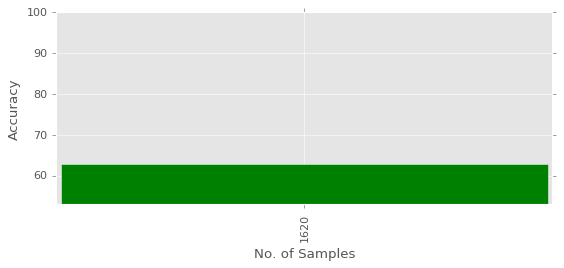

In [200]:
# Main

def main():
    
    NUM_ITERATIONS_PER_SET = 5
    
    run_algorithm('svm', data_public, num_iter=NUM_ITERATIONS_PER_SET, handle_cold_start=True, label='svm_public')
    run_algorithm('svm', data_ds1, num_iter=1, handle_cold_start=False, label='svm_ds1')
    run_algorithm('svm', data_ds2, num_iter=1, handle_cold_start=False, label='svm_ds2')
    
    run_algorithm('ffnn', data_public, num_iter=NUM_ITERATIONS_PER_SET, handle_cold_start=True, label='ffnn_public')
    run_algorithm('ffnn', data_ds1, num_iter=1, handle_cold_start=False, label='ffnn_ds1')
    run_algorithm('ffnn', data_ds2, num_iter=1, handle_cold_start=False, label='ffnn_ds2')
    
    run_algorithm('cnn', data_public, num_iter=NUM_ITERATIONS_PER_SET, handle_cold_start=True, label='cnn_public')
    run_algorithm('cnn', data_ds1, num_iter=1, handle_cold_start=False, label='cnn_ds1')
    run_algorithm('cnn', data_ds2, num_iter=1, handle_cold_start=False, label='cnn_ds2')
    
main()

In [192]:
# This section and rest are just tests
def extract_features(imagePath, vector_size=32):
    image = imageio.imread(imagePath)
    alg = cv2.KAZE_create()
    kps = alg.detect(image)
    kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
    print (len(kps))
    kps, dsc = alg.compute(image, kps)
    print (len(dsc))
    print (len(dsc[0]))
    dsc = dsc.flatten()
    print (len(dsc))
    needed_size = (vector_size * 32)
    if dsc.size < needed_size:
        dsc = numpy.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    return dsc

def main2():
    #features = create_feature_vector("SpamImages", "fire.jpg")
    #print len(features)
    #print features
    #image = cv2.imread("SpamImages/fire.jpg")
    #plotImage(image)
    #image2 = cv2.resize(image, (600, 600))
    #plotImage(image2)
    
    
    """data = get_feature_with_labels()
    data"""
    
    #print (len(data[0]))
    
    

    #create_feature_vector_for_canny("NaturalImages", origImageName)
    
    #plainImageFileName = "SpamImages/boots1.jpg"
    """plainImage =  cv2.imread(plainImageFileName)
    shape_hog(plainImage, "HOG-Ham.png")
    
    #plt.imshow(plainImage, cmap = 'gray', interpolation = 'bicubic')
    #plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    #plt.show()
    cv_rgb = cv2.cvtColor(plainImage, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    
    plainImage2 =  cv2.imread("HOG-Ham.png")

    print "hi"
    
    cv_rgb2 = cv2.cvtColor(plainImage2, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb2)
    plt.show()

    shape_cannyEdges(plainImage)
    cv_rgb2 = cv2.cvtColor(cv2.imread("Cannyedges.jpg"), cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb2)
    plt.show()"""
    
    #x = create_feature_vector_for_canny("SpamImages", "fire.jpg", 3.0)
    numpy.set_printoptions(threshold=100)
    #print x
    
    x = numpy.ndarray((10, 3))
    print(x)
    train_len = int(len(x) * .7)
    #print x[0:train_len]
    #print "sep"
    #print x[train_len:]
    
    num_col = len(x[0]) - 1
    
    print(x[:,0:num_col])
    
    print(x[:, num_col:].flatten())